# Chapter 4: Solving Differential Equations

## Numerical integration of initial value problems

### First order differential equations

Parameters of a Strömgren sphere

In [2]:
pip install astropy

     |████████████████████████████████| 10.7 MB 4.2 MB/s            
     |████████████████████████████████| 746 kB 55.4 MB/s            
Note: you may need to restart the kernel to use updated packages.


In [3]:
import numpy as np
import astropy.units as unit

n0 = 5000 * 1/unit.cm**3 # number density of HI
S = 1.6e49 * 1/unit.s # ionizing photons emitted per second
alpha = 3.1e-13 * unit.cm**3/unit.s # recombination coefficient

rs = (3*S/(4*np.pi * n0**2 * alpha))**(1/3)
print("Strömgren radius = {:.2f}".format(rs.to(unit.pc)))

Strömgren radius = 0.26 pc


Euler method using variables in cgs system

In [4]:
n0_cgs = n0.value
alpha_cgs = alpha.value
rs_cgs = rs.value

# time step in s
dt = 100
n_steps = 1000

# intialization of arrays for t and r(t)
t = np.linspace(0, n_steps*dt, n_steps+1)
r = np.zeros(n_steps+1)

# start radius in cm
r[0] = 1e16

# Euler integration
for n in range(n_steps):
    rdot = n0_cgs * alpha_cgs * (rs_cgs**3 - r[n]**3)/(3*r[n]**2)
    r[n+1] = r[n] + rdot * dt

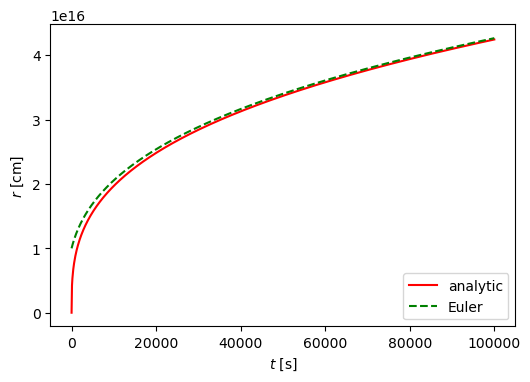

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure(figsize=(6, 4), dpi=100)
plt.plot(t, rs_cgs*(1 - np.exp(-n0_cgs*alpha_cgs*t))**(1/3), 
         linestyle='-' , color='red' , label="analytic")
plt.plot(t, r, linestyle='--' , color='green' , label="Euler")
plt.legend(loc='lower right')
plt.xlabel("$t$ [s]")
plt.ylabel("$r$ [cm]")
plt.savefig("stroemgren_cgs.pdf")

Shift of time coordinate $t'=t-t_0$

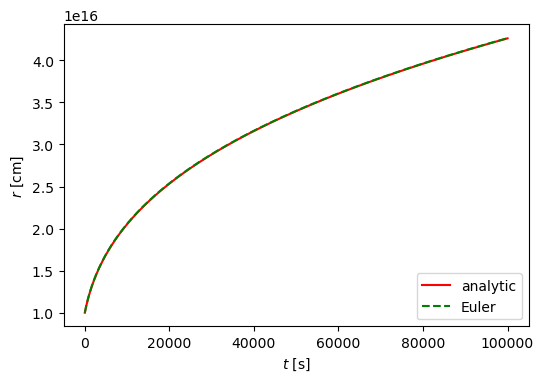

In [6]:
t0 = np.log(1 - (r[0]/rs_cgs)**3) / (n0_cgs*alpha_cgs)

fig = plt.figure(figsize=(6, 4), dpi=100)
plt.plot(t, rs_cgs*(1.0 - np.exp(-n0_cgs*alpha_cgs*(t-t0)))**(1/3), 
         linestyle='-' , color='red' , label="analytic")
plt.plot(t, r, linestyle='--' , color='green' , label="Euler")
plt.legend(loc='lower right')
plt.xlabel("$t$ [s]")
plt.ylabel("$r$ [cm]")
plt.show()

Formation time scale $t_{\rm s}$

In [7]:
ts = 1/(n0*alpha)
print("Time scale = {:.2f}".format(ts.to(unit.yr)))

Time scale = 20.44 yr


Plots above ends at a time $t\ll t_{\rm s}$

In [8]:
t[-1]*unit.s/ts

<Quantity 0.000155>

Euler method using dimensionless variables

Integrating 2000 steps for dt = 1e-03
Integrating 20000 steps for dt = 1e-04
Integrating 200000 steps for dt = 1e-05


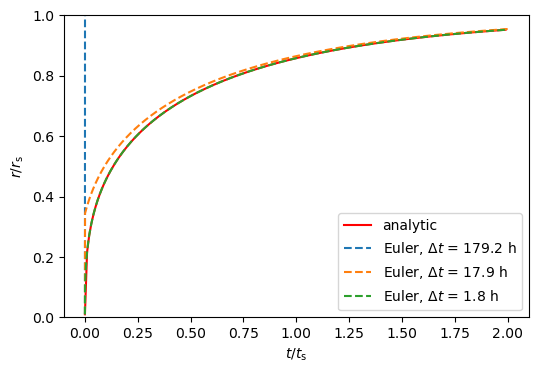

In [9]:
# initial radius
r0 = 0.01

# analytic solution 
t0 = np.log(1 - r0**3)
t = np.arange(0, 2.0, 0.01)

fig = plt.figure(figsize=(6, 4), dpi=100)
plt.plot(t, (1 - np.exp(-t+t0))**(1/3), color='red' , label="analytic")

dt = 1e-3
n_steps = 2000

while dt >= 1e-5:
    t = np.linspace(0, n_steps*dt, n_steps+1)
    r = np.zeros(n_steps+1)
    r[0] = r0

    print("Integrating {:d} steps for dt = {:.0e}".format(n_steps,dt))
    for n in range(n_steps):
        rdot = (1 - r[n]**3)/(3*r[n]**2)
        r[n+1] = r[n] + rdot * dt
    
    # plot the new data
    plt.plot(t, r, linestyle='--' , 
             label="Euler, $\Delta t$ = {:.1f}".format(dt*ts.to(unit.hr)))
    
    # decrease time step by a factor of 10
    dt *= 0.1
    n_steps *= 10

plt.legend(loc='lower right')
plt.xlabel("$t/t_{\mathrm{s}}$")
plt.ylabel("$r/r_{\mathrm{s}}$")
plt.ylim(0,1)
plt.savefig("stroemgren_dimensionless.pdf")

Runge-Kutta (RK4) scheme

In [10]:
def rk4_step(f, t, x, dt):

    k1 = dt * f(t, x)
    k2 = dt * f(t + 0.5*dt, x + 0.5*k1)
    k3 = dt * f(t + 0.5*dt, x + 0.5*k2)
    k4 = dt * f(t + dt, x + k3) 

    return x + (k1 + 2*(k2 + k3) + k4)/6

Integrating 2000 steps for dt = 1e-03, endpoint deviation = 2.08e-01
Integrating 20000 steps for dt = 1e-04, endpoint deviation = 2.23e-04
Integrating 200000 steps for dt = 1e-05, endpoint deviation = 2.26e-07


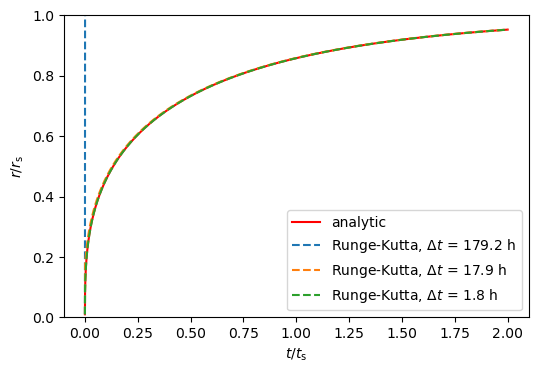

In [11]:
fig = plt.figure(figsize=(6, 4), dpi=100)
plt.plot(t, (1 - np.exp(-t+t0))**(1/3), color='red' , label="analytic")

dt = 1e-3
n_steps = 2000

while dt >= 1e-5:
    t = np.linspace(0, n_steps*dt, n_steps+1)
    r = np.zeros(n_steps+1)
    r[0] = r0

    print("Integrating {:d} steps for dt = {:.0e}".format(n_steps,dt), end=",")
    for n in range(n_steps):
        r[n+1] = rk4_step(lambda t, r: (1 - r**3)/(3*r**2),
                          t[n], r[n], dt)

    # plot the new data
    plt.plot(t, r, linestyle='--' , 
             label="Runge-Kutta, $\Delta t$ = {:.1f}".format(dt*ts.to(unit.hr)))
    
    print(" endpoint deviation = {:.2e}".
          format(r[-1] - (1 - np.exp(-t[-1]+t0))**(1/3)))
    
    # decrease time step by a factor of 10
    dt *= 0.1
    n_steps *= 10

plt.legend(loc='lower right')
plt.xlabel("$t/t_{\mathrm{s}}$")
plt.ylabel("$r/r_{\mathrm{s}}$")
plt.ylim(0,1)
plt.savefig("stroemgren_rk4.pdf")

### Second order differential equations

Differential equation for damped harmonic oscillator

In [12]:
def xddot(t, x, xdot, m, d, k):
    """
    acceleration function of damped harmonic oscillator
    
    args: t    - time
          x    - position
          xdot - velocity
          m - mass
          d - damping constant
          k - spring constant

    returns: positions (unit amplitude)
    """
    return -(d*xdot + k*x)/m

In [13]:
def euler_forward(f, t, x, xdot, h, *args):
    """
    Euler forward step for function x(t)
    given by second order differential equation

    args: f - function determining second derivative
          t - value of independent variable t
          x - value of x(t)
          xdot - value of first derivative dx/dt
          h - time step
          args - parameters

    returns: iterated values for t + h
    """
    return ( x + h*xdot, xdot + h*f(t, x, xdot, *args) )

Solution of differential equation with Euler and RKN4 methods

In [14]:
import numpy as np

# parameters
m = 1.
d = 0.05
k = 0.5
x0 = 10

n = 1000 # number of time steps
dt = 0.05 # time step
t = np.arange(0, n*dt, dt)

# intialization of data arrays for numerical solutions
x_fe = np.zeros(n)
v_fe = np.zeros(n)

# initial data for t = 0 
x_fe[0], v_fe[0] = x0, 0

# compute numerical solution by applying the forward Euler method
for i in range(n-1):
    x_fe[i+1], v_fe[i+1] = \
        euler_forward(xddot, t[i], x_fe[i], v_fe[i], dt, m, d, k)

Analytic solution

In [15]:
def osc(t, m, d, k):
    """
    normalized damped harmonic oscillator
    with zero velocity at t = 0

    args: t - array of time values
          m - mass
          d - damping constant
          k - spring constant

    returns: positions (unit amplitude)
    """
    
    try:
        if m > 0 and d > 0 and k > 0: # positive parameters
            gamma = 0.5*d/m
            omega0 = np.sqrt(k/m)
            if omega0 >= gamma: # underdamped or critical
                # frequency of damped oscillation
                omega = np.sqrt(omega0**2 - gamma**2)
                print("Angular frequency = {:.6e}".format(omega))
                return np.exp(-gamma*t) * \
                    (np.cos(omega*t) + gamma*np.sin(omega*t)/omega)
            else:
                raise ValueError
        else:
            raise ValueError
            
    except ValueError:
        print("Invalid argument: non-positive mass or overdamped")
        return None

In [16]:
# analytic solution
x = x0*osc(t, m, d, k)

# relative deviation from analytic solution
dev_fe = np.fabs((x - x_fe)/x)

Angular frequency = 7.066647e-01


In [17]:
# apply symplectic Euler and RKN4 schemes 
from numkit import euler_step, rkn4_step

x_rkn4 = np.zeros(n)
v_rkn4 = np.zeros(n)

x_se = np.zeros(n)
v_se = np.zeros(n)

x_rkn4[0], v_rkn4[0] = x0, 0
x_se[0], v_rkn4[0] = x0, 0

for i in range(n-1):
    x_rkn4[i+1], v_rkn4[i+1] = \
        rkn4_step(xddot, t[i], x_rkn4[i], v_rkn4[i], dt, m, d, k)
    x_se[i+1], v_se[i+1] = \
        euler_step(xddot, t[i], x_se[i], v_se[i], dt, m, d, k)

dev_rkn4 = np.fabs((x - x_rkn4)/x)
dev_se = np.fabs((x - x_se)/x)

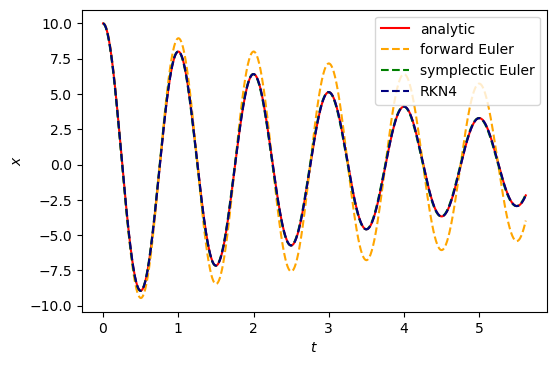

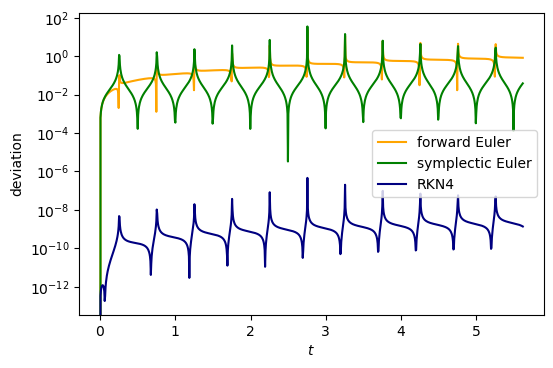

In [18]:
import matplotlib.pyplot as plt
%matplotlib inline

T = 2*np.pi/7.066647e-01 # period

fig = plt.figure(figsize=(6, 4), dpi=100)
plt.plot(t/T, x, linestyle='-' , color='red' , label="analytic")
plt.plot(t/T, x_fe, linestyle='--' , color='orange' , label="forward Euler")
plt.plot(t/T, x_se, linestyle='--' , color='green' , label="symplectic Euler")
plt.plot(t/T, x_rkn4, linestyle='--' , color='navy' , label="RKN4")
plt.legend(loc='upper right')
plt.xlabel("$t$")
plt.ylabel("$x$")
plt.savefig("oscillator.pdf")

fig = plt.figure(figsize=(6, 4), dpi=100)
plt.semilogy(t/T, dev_fe, linestyle='-', color='orange', label='forward Euler')
plt.semilogy(t/T, dev_se, linestyle='-', color='green', label='symplectic Euler')
plt.semilogy(t/T, dev_rkn4, linestyle='-' , color='navy', label='RKN4')
plt.legend(loc='right')
plt.xlabel("$t$")
plt.ylabel("deviation")
plt.savefig("oscillator_delta.pdf")

## Radial fall

In [19]:
import numpy as np
import astropy.units as unit
from astropy.constants import G,M_earth,R_earth

#### Tunguska-like asteroid

Estimates of the impact velocity and kinetic energy of a asteroid comparable to Tunguska

In [20]:
v0 = np.sqrt(2*G*M_earth/R_earth)
print("Impact velocity = {:.3e}".format(v0))

Impact velocity = 1.118e+04 m / s


In [21]:
# asteroid parameters
R = 34*unit.m                  # radius
V = (4*np.pi/3) * R**3         # volume
rho = 2.2e3*unit.kg/unit.m**3  # density
m = rho*V                      # mass

energy_kin = 0.5*m*v0**2
print("Asteroid mass = {:.1e}, estimated kinetic energy = {:.1e}".format(m,energy_kin.to(unit.J)))

Asteroid mass = 3.6e+08 kg, estimated kinetic energy = 2.3e+16 J


#### Integration of equation of motion with air resistance

In [22]:
h0 = 300*unit.km
v0 = np.sqrt(2*G*M_earth/(R_earth + h0))

From now on, we drop units for numerical computations (all variables are in SI units).

The module ```numkit``` is provided is part of the zip archive.

In [23]:
from numkit import rkn4_step

# drag coefficient
c_drag = 0.5

# barometric height formula
def rho_air(h):
    return 1.3*np.exp(-h/8.4e3)

# acceleration of the asteroid
def hddot(t, h, hdot, m, R):
    
    # air resistance
    F_drag =0.5*rho_air(h)*c_drag * np.pi*R**2 * hdot**2
    
    # gravity at height h
    g_h = G.value * M_earth.value / (R_earth.value + h)**2
    
    return -g_h + F_drag/m

In [24]:
# initial data
data = [[0, h0.to(unit.m).value, -v0.value]]

# initialization of loop variables
t, h, hdot = tuple(data[0])
print("Initial acceleration = {:.2f} m/s^2".
      format(hddot(0, h, hdot, m.value, R.value)))

# time step
dt = 0.1

while h > 0:
    h, hdot = rkn4_step(hddot, t, h, hdot, dt, 
                        m.value, R.value)
    t += dt
    data = np.append(data, [[t, h, hdot]], axis=0)

Initial acceleration = -8.94 m/s^2


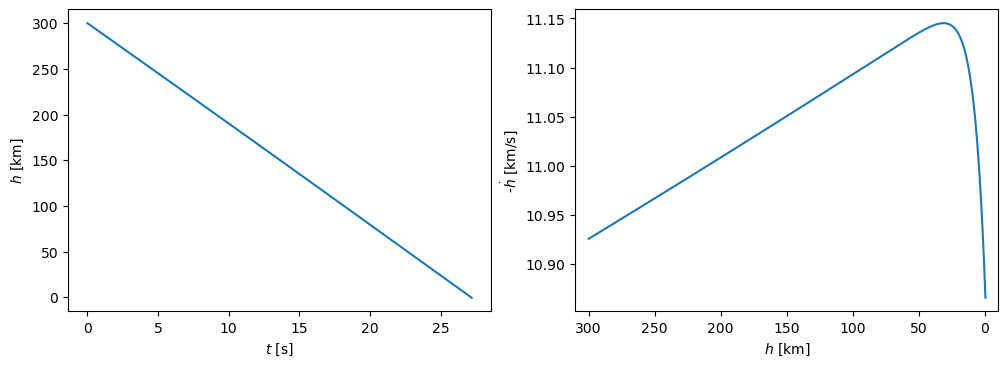

In [25]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,4), dpi=100)

plt.subplot(121)
plt.plot(data[:,0], 1e-3*data[:,1])
plt.xlabel("$t$ [s]")
plt.ylabel("$h$ [km]" )

plt.subplot(122)
plt.plot(1e-3*data[:,1], -1e-3*data[:,2])
plt.xlim(h0.value+10,-10)
plt.xlabel("$h$ [km]")
plt.ylabel("-$\dot{h}$ [km/s]" )
plt.savefig("asteroid.pdf")

#### Energy dissipation

In [26]:
def dissipation(h, hdot, m, R):
    return -0.5*rho_air(h)*c_drag * np.pi*R**2 * hdot**3

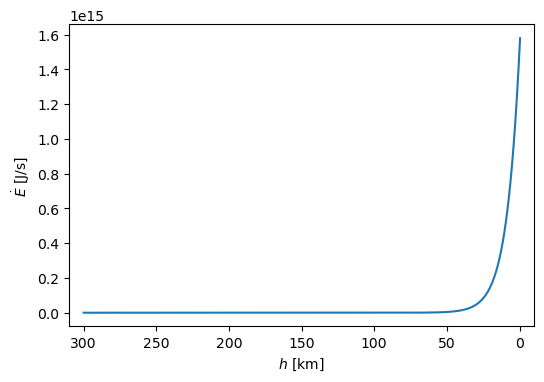

In [27]:
plt.figure(figsize=(6,4), dpi=100)

plt.plot(1e-3*data[:,1], dissipation(data[:,1], data[:,2], m.value, R.value))
plt.xlim(h0.value+10,-10)
plt.xlabel("$h$ [km]")
plt.ylabel("$\dot{E}$ [J/s]" )
plt.savefig("asteroid_diss.pdf")

In [28]:
def integr_trapez(y, h):
    """
    numerical integration of a function
    given by discrete data

    args: y - array of function values
          h - spacing between x values       

    returns: approximate integral
    """
    return 0.5*h*(y[0] + 2*np.sum(y[1:-1]) + y[-1])

In [29]:
a, b = 0, np.pi/2
n = 10
x = np.linspace(a, b, n+1)
y = np.sin(x)

In [30]:
integr_trapez(y, (b-a)/n)

0.9979429863543572

In [31]:
np.trapz(y, dx=(b-a)/n)

0.9979429863543573

In [32]:
energy_diss = integr_trapez(dissipation(data[:,1], data[:,2], m.value, R.value), dt)*unit.J
print("Fraction of dissipated energy = {:.2f} %".format(100*energy_diss/energy_kin.to(unit.J)))

Fraction of dissipated energy = 5.55 %


## Orbital mechanics

### Two-body problem

In [33]:
import numpy as np
from astropy.constants import M_sun
from scipy.constants import G,year,au

M1 = 2.06*M_sun.value # mass of Sirius A
M2 = 1.02*M_sun.value # mass of Sirius B

a = 2.64*7.4957*au # semi-major axis
e = 0.5914

Orbital period computed from Kepler's third law

In [34]:
T = 2*np.pi * (G*(M1 + M2))**(-1/2) * a**(3/2)

print("Orbital period = {:.1f} yr".format(T/year))

Orbital period = 50.2 yr


In [35]:
n_rev = 3      # number of revolutions
n = n_rev*500  # number of time steps
dt = n_rev*T/n # time step
t = np.arange(0, (n+1)*dt, dt)

# data arrays for coordinates
x1 = np.zeros(n+1)
y1 = np.zeros(n+1)
x2 = np.zeros(n+1)
y2 = np.zeros(n+1)

# data arrays for velocity components
vx1 = np.zeros(n+1)
vy1 = np.zeros(n+1)
vx2 = np.zeros(n+1)
vy2 = np.zeros(n+1)

Initial data: start at periastron

In [36]:
# periastron distance and relative velocity
d = a*(1 - e)
v = np.sqrt(G*(M1 + M2)*(2/d - 1/a)) # vis-viva eq.

x1[0], y1[0] =  d*M2/(M1 + M2), 0
x2[0], y2[0] = -d*M1/(M1 + M2), 0

vx1[0], vy1[0] = 0, -v*M2/(M1 + M2)
vx2[0], vy2[0] = 0,  v*M1/(M1 + M2)

In [37]:
alpha = G*M1*M2

#### Forward Euler method

In [38]:
for i in range(n):
    
    delta_x = x2[i] - x1[i]
    delta_y = y2[i] - y1[i]
    
    # third power of distance 
    d3 = (delta_x**2 + delta_y**2)**(3/2)
    
    # force components
    Fx = alpha*delta_x/d3
    Fy = alpha*delta_y/d3
    
    # forward Euler velocity updates
    vx1[i+1] = vx1[i] + Fx*dt/M1
    vy1[i+1] = vy1[i] + Fy*dt/M1
    vx2[i+1] = vx2[i] - Fx*dt/M2
    vy2[i+1] = vy2[i] - Fy*dt/M2
    
    # forward Euler position updates
    x1[i+1] = x1[i] + vx1[i]*dt
    y1[i+1] = y1[i] + vy1[i]*dt
    x2[i+1] = x2[i] + vx2[i]*dt
    y2[i+1] = y2[i] + vy2[i]*dt

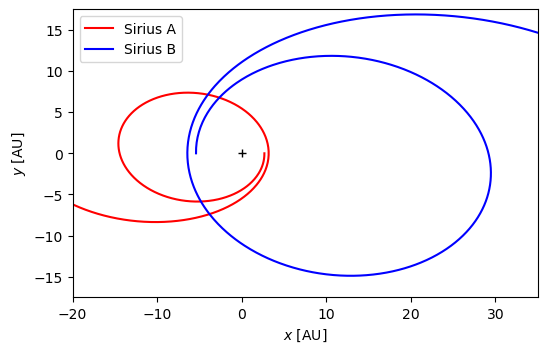

In [39]:
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure(figsize=(6, 6*35/55), dpi=100)

plt.plot([0], [0], '+k')  # center of mass
plt.plot(x1/au, y1/au, color='red', label='Sirius A')
plt.plot(x2/au, y2/au, color='blue', label='Sirius B')

plt.xlabel("$x$ [AU]")
plt.xlim(-20,35)
plt.ylabel("$y$ [AU]")
plt.ylim(-17.5,17.5)
plt.legend(loc='upper left')
plt.savefig("sirius_forward.pdf")

#### Symplectic Euler method

In [40]:
for i in range(n):
    
    delta_x = x2[i] - x1[i]
    delta_y = y2[i] - y1[i]
    
    # third power of distance 
    d3 = (delta_x**2 + delta_y**2)**(3/2)
    
    # force components
    Fx = alpha*delta_x/d3
    Fy = alpha*delta_y/d3
    
    # forward Euler velocity updates
    vx1[i+1] = vx1[i] + Fx*dt/M1
    vy1[i+1] = vy1[i] + Fy*dt/M1
    vx2[i+1] = vx2[i] - Fx*dt/M2
    vy2[i+1] = vy2[i] - Fy*dt/M2
    
    # forward Euler position updates
    x1[i+1] = x1[i] + vx1[i+1]*dt
    y1[i+1] = y1[i] + vy1[i+1]*dt
    x2[i+1] = x2[i] + vx2[i+1]*dt
    y2[i+1] = y2[i] + vy2[i+1]*dt

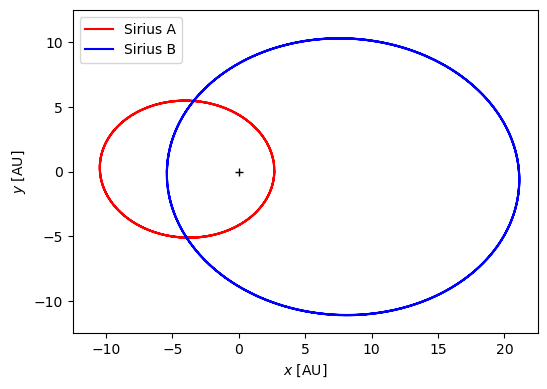

In [41]:
fig = plt.figure(figsize=(6, 6*25/35), dpi=100)

plt.plot([0], [0], '+k')  # center of mass
plt.plot(x1/au, y1/au, color='red', label='Sirius A')
plt.plot(x2/au, y2/au, color='blue', label='Sirius B')

plt.xlabel("$x$ [AU]")
plt.xlim(-12.5,22.5)
plt.ylabel("$y$ [AU]")
plt.ylim(-12.5,12.5)
plt.legend(loc='upper left')
plt.savefig("sirius_symplectic.pdf")

#### SciPy integrator

See [docs.scipy.org/doc/scipy/reference/integrate.html](https://docs.scipy.org/doc/scipy/reference/integrate.html) for an overview.

In [42]:
from scipy.integrate import solve_ivp

init_state = np.array([ x1[0],  y1[0],  x2[0],  y2[0], 
                       vx1[0], vy1[0], vx2[0], vy2[0]])

In [43]:
def state_derv(t, state):
    alpha = G*M1*M2

    delta_x = state[2] - state[0] # x2 - x1
    delta_y = state[3] - state[1] # y2 - y1
    
    # third power of distance 
    d3 = (delta_x**2 + delta_y**2)**(3/2)
    
    # force components
    Fx = alpha*delta_x/d3
    Fy = alpha*delta_y/d3

    return np.array([state[4], state[5], state[6], state[7], 
                     Fx/M1, Fy/M1, -Fx/M2, -Fy/M2])

Default tolerance

In [44]:
tmp = solve_ivp(state_derv, (0,3*T), init_state, dense_output=True)
data = tmp.sol(t)

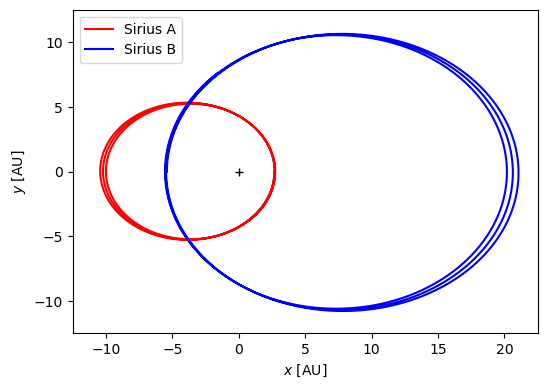

In [45]:
fig = plt.figure(figsize=(6, 6*25/35), dpi=100)

plt.plot([0], [0], '+k')  # center of mass
plt.plot(data[0,:]/au, data[1,:]/au, color='red', label='Sirius A')
plt.plot(data[2,:]/au, data[3,:]/au, color='blue', label='Sirius B')

plt.xlabel("$x$ [AU]")
plt.xlim(-12.5,22.5)
plt.ylabel("$y$ [AU]")
plt.ylim(-12.5,12.5)
plt.legend(loc='upper left')
plt.savefig("sirius_scipy.pdf")

### Algol star system

In [46]:
from scipy.constants import day

M1 = 3.17*M_sun.value # mass of Algol Aa1
M2 = 0.70*M_sun.value # mass of Algol Aa2
M3 = 1.76*M_sun.value # mass of Algol Ab

# inner orbit (Aa1 and Aa2)
T12 = 2.867*day
e12 = 0

# outer orbit (Aa and Ab)
T = 680.2*day
e = 0.227

Initial positions and velocities following from two-body approximations for Aa1/2 andAa/b

In [47]:
from scipy.constants import day

a12 = (T12/(2*np.pi))**(2/3) * (G*(M1 + M2))**(1/3)
a = (T/(2*np.pi))**(2/3) * (G*(M1 + M2 + M3))**(1/3)

print("Inner semi-major axis = {:.2e} AU".format(a12/au))
print("Outer semi-major axis = {:.2f} AU".format(a/au))

Inner semi-major axis = 6.20e-02 AU
Outer semi-major axis = 2.69 AU


In [48]:
M12 = M1 + M2
d12 = a12*(1 - e12)
v12 = np.sqrt(G*M12*(2/d12 - 1/a12))

x1, y1 =  d12*M2/M12, 0
x2, y2 = -d12*M1/M12, 0

vx1, vy1 = 0, -v12*M2/M12
vx2, vy2 = 0,  v12*M1/M12

In [49]:
d = a*(1 - e)
v = np.sqrt(G*(M12 + M3)*(2/d - 1/a))

x1 += d*M3/(M12 + M3) 
x2 += d*M3/(M12 + M3)

x3, y3 = -d*M12/(M12 + M3), 0

vy1 -= v*M3/(M12 + M3)
vy2 -= v*M3/(M12 + M3)

vx3, vy3 = 0, v*M12/(M12 + M3)

Initial state ${\bf s}_0$

In [50]:
init_state = np.array([ x1,  y1,  x2,  y2,  x3,  y3, 
                       vx1, vy1, vx2, vy2, vx3, vy3])

Derviative function ${\bf f}(t,{\bf s})$

In [51]:
def state_derv(t, state):
    alpha = G*M1*M2
    beta = G*M1*M3
    gamma = G*M2*M3

    delta12_x = state[2] - state[0] # x2 - x1
    delta12_y = state[3] - state[1] # y2 - y1
    
    delta13_x = state[4] - state[0] # x3 - x1
    delta13_y = state[5] - state[1] # y3 - y1
    
    delta23_x = state[4] - state[2] # x3 - x2
    delta23_y = state[5] - state[3] # y3 - y2
        
    # force components
    F12x = alpha*delta12_x/(delta12_x**2 + delta12_y**2)**(3/2)
    F12y = alpha*delta12_y/(delta12_x**2 + delta12_y**2)**(3/2)
    
    F13x =  beta*delta13_x/(delta13_x**2 + delta13_y**2)**(3/2)
    F13y =  beta*delta13_y/(delta13_x**2 + delta13_y**2)**(3/2)

    F23x = gamma*delta23_x/(delta23_x**2 + delta23_y**2)**(3/2)
    F23y = gamma*delta23_y/(delta23_x**2 + delta23_y**2)**(3/2)

    return np.array([state[6], state[7], 
                     state[8], state[9], 
                     state[10], state[11],  
                     ( F12x + F13x)/M1, ( F12y + F13y)/M1, 
                     (-F12x + F23x)/M2, (-F12y + F23y)/M2,
                     (-F13x - F23x)/M3, (-F13y - F23y)/M3])

Apply numerical solver

In [52]:
tmp = solve_ivp(state_derv, (0,0.5*T), init_state, dense_output=True, rtol=1e-6)
data = tmp.y

In [53]:
print(tmp.nfev)

17222


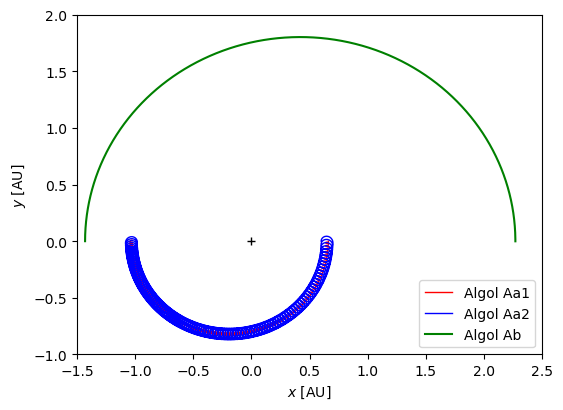

In [54]:
fig = plt.figure(figsize=(6,6*3/4), dpi=100)

plt.plot([0], [0], '+k')  # center of mass
plt.plot(data[0,:]/au, data[1,:]/au, color='red', lw=1, label='Algol Aa1')
plt.plot(data[2,:]/au, data[3,:]/au, color='blue', lw=1, label='Algol Aa2')
plt.plot(data[4,:]/au, data[5,:]/au, color='green', label='Algol Ab')

plt.xlabel("$x$ [AU]")
plt.xlim(-1.5,2.5)
plt.ylabel("$y$ [AU]")
plt.ylim(-1,2)
plt.legend(loc='lower right')
plt.savefig("algol.pdf")

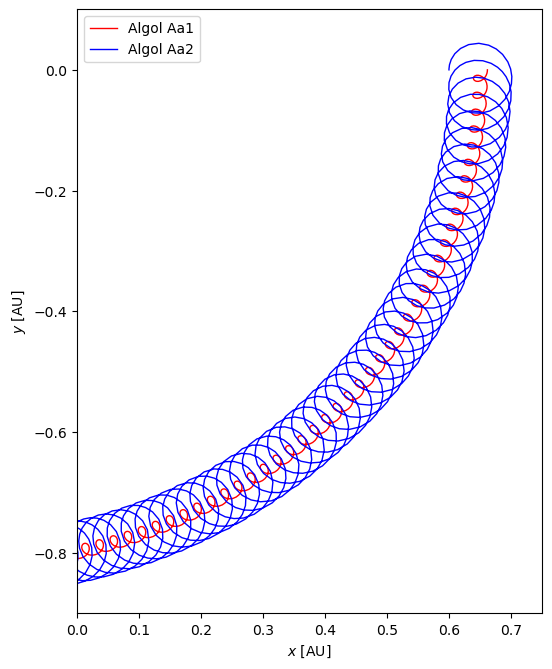

In [55]:
fig = plt.figure(figsize=(6,6*1/0.75), dpi=100)

plt.plot(data[0,:]/au, data[1,:]/au, color='red', lw=1, label='Algol Aa1')
plt.plot(data[2,:]/au, data[3,:]/au, color='blue', lw=1, label='Algol Aa2')

plt.xlabel("$x$ [AU]")
plt.xlim(0,0.75)
plt.ylabel("$y$ [AU]")
plt.ylim(-0.9,0.1)
plt.legend(loc='upper left')
plt.savefig("algol_inner.pdf")